In [1]:
import numpy as np
import matplotlib.pyplot as plt
import amstrax
import strax
%matplotlib inline

In [2]:
run_id = '190124_114450'

In [3]:
!rm -rf ./strax_data/190124_114450-peaks-*

In [4]:
st = strax.Context(storage=strax.DataDirectory('./strax_data'),
                   register = [amstrax.RecordsFromMongo, amstrax.Records, amstrax.Peaks],
                   config=dict(collection_name = run_id, events_per_chunk = 1000, 
                               software_zle_hitfinder_threshold=10, software_zle_channels = [0, 1,2,3,4,5,6,7],
                               software_zle_extension = 20, hitfinder_threshold = 10, min_hits=1
                              ))

In [5]:
%%time
st.make(run_id, 'raw_records')

CPU times: user 933 ms, sys: 212 ms, total: 1.14 s
Wall time: 624 ms


In [6]:
st.make(run_id, 'records')

In [7]:
st.make(run_id, 'peaks')

In [8]:
p = st.get_array(run_id, 'peaks')

In [10]:
st.data_info('peaks')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,float32,Integral across channels in photoelectrons
5,area_per_channel,"('<i4', (16,))",Integral per channel in ADX x samples (not PE!)
6,n_hits,int16,Number of hits from which peak was constructed...
7,data,"('<f4', (200,))",Waveform data in PE/sample (not PE/ns!)
8,width,"('<f4', (11,))",Peak widths in ns: range of central area fraction
9,saturated_channel,"('<i2', (16,))",Check if channel is saturated


In [12]:
r = st.get_array(run_id, 'records')

In [14]:
strax.sum_waveform(p, r, np.ones(16), n_channels=16)

AssertionError: 

In [25]:
def sum_waveform(peaks, records, adc_to_pe, n_channels=248):
    """Compute sum waveforms for all peaks in peaks
    Will downsample sum waveforms if they do not fit in per-peak buffer
    
    :param n_channels: Number of channels that contribute to the total area
    and n_saturated_channels.
    For further channels we still calculate area_per_channel and saturated_channel.
    Assumes all peaks and pulses have the same dt
    """
    if not len(records):
        return
    if not len(peaks):
        return
    dt = records[0]['dt']
    sum_wv_samples = len(peaks[0]['data'])

    # Big buffer to hold even largest sum waveforms
    # Need a little more even for downsampling..
    swv_buffer = np.zeros(peaks['length'].max() * 2, dtype=np.float32)

    # Index of first record that could still contribute to subsequent peaks
    # Records before this do not need to be considered anymore
    left_r_i = 0

    for peak_i, p in enumerate(peaks):
        # Clear the relevant part of the swv buffer for use
        # (we clear a bit extra for use in downsampling)
        p_length = p['length']
        swv_buffer[:min(2 * p_length, len(swv_buffer))] = 0

        # Find first record that contributes to this peak
        for left_r_i in range(left_r_i, len(records)):
            r = records[left_r_i]
            # TODO: need test that fails if we replace < with <= here
            if p['time'] < r['time'] + r['length']:
                break
        else:
            # Records exhausted before peaks exhausted
            # TODO: this is a strange case, maybe raise warning/error?
            break

        # Scan over records that overlap
        for right_r_i in range(left_r_i, len(records)):
            r = records[right_r_i]
            ch = r['channel']

            s = int((p['time'] - r['time']) // dt)
            n_r = r['length']
            n_p = p_length

            if s <= -n_p:
                # Record is completely to the right of the peak;
                # we've seen all overlapping records
                break

            # Range of record that contributes to peak
            r_start = max(0, s)
            r_end = min(n_r, s + n_p)
            if not r_end > r_start:
                print('Record index: ', right_r_i)
                print('peak index: ', peak_i)
            assert r_end > r_start
            
            max_in_record = r['data'][r_start:r_end].max()
            p['saturated_channel'][ch] = int(max_in_record < r['baseline'])

            # TODO Do we need .astype(np.int32).sum() ??
            p['area_per_channel'][ch] += r['data'][r_start:r_end].sum()
            
            # Range of peak that receives record
            p_start = max(0, -s)
            p_end = min(n_p, -s + n_r)

            assert p_end - p_start == r_end - r_start, "Ouch, off-by-one error"

            if p_end - p_start > 0:
                swv_buffer[p_start:p_end] += \
                    r['data'][r_start:r_end] * adc_to_pe[ch]

        # Store the sum waveform
        # Do we need to downsample the swv to store it?
        downs_f = int(np.ceil(p_length / sum_wv_samples))
        if downs_f > 1:
            # New number of samples in the peak
            new_ns = p['length'] = int(np.ceil(p_length / downs_f))
            p['data'][:new_ns] = \
                swv_buffer[:new_ns * downs_f].reshape(-1, downs_f).sum(axis=1)
            p['dt'] *= downs_f
        else:
            p['data'][:p_length] = swv_buffer[:p_length]

        # Store the total area and saturation count
        p['area'] = (p['area_per_channel'][:n_channels] * adc_to_pe[:n_channels]).sum()
        p['n_saturated_channels'] = p['saturated_channel'][:n_channels].sum()


In [26]:
sum_waveform(p, r, np.ones(16), n_channels=16)

Record index:  13758
peak index:  5911


AssertionError: 

In [27]:
p[5911]

(-1, 10, 9419946, 18, 0., [  0,   0,   0,   0,   0,   0,   0,   0, -45,   0,   0,   0,   0,   0,   0,   0], 1, [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [29]:
r[13757]

(8, 10, 9419906, 96, 25, 96, 0, -8359.3, 0, [-4, -2, -2,  1, -3,  1,  1,  1,  1, -1,  1,  2, -1, -2, -1, -2, -2, -1,  2, -1, -3, -1, -1, -1,  0, -1,  1, -1, -1,  0,  1,  1, -1, -1, -1,  0,  6, 13,  7,  7,  4,  2,  0, -1, -3, -2,  0,  1,  0,  0,  1,  0, -1, -3, 10, 13,  8,  5,  5,  1,  2, -2, -2, -1, -1, -2,  0, -1, -1,  1,  0,  3, -1, -1, -2, -2,  0, -3, -2, -2, -2, -2,  0,  0, -1, -1,  0,  0,  0, -1,  1,  0, -2, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [30]:
r[13758]

(8, 10, 9419922, 2, -3, 112, 1, -8359., 0, [-1, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [44]:
np.where(np.invert((r['time'] + r['length'] * r['dt'])[:-1] <= r['time'][1:]))

(array([      6,       7,       8, ..., 1370522, 1370523, 1370524]),)

In [48]:
time_to_next_pulse = (r['time'][1:] - (r['time'] + r['length'] * r['dt'])[:-1])

In [50]:
time_to_next_pulse[:100]

array([   40,    40,     0,    20,    40,    20,  -320,  -460,  -320,
        -480,    20,  -440,  -340,  -440,  -620,  -200,  -320,  -460,
        -320,  -460,  -544,  -276,  -804,  -736,  -100,  -184,  -796,
        -640,  -400,  -804,  -236,  -544,  -696,  -400,  -144,  -716,
        -600,  -160,  -784,  -576,  -498,  -786,  -816,  -840,  -298,
        -786,  -576,  -400,  -380,  -778,  -786,  -576,  -340,  -758,
        -566,  -676,  -498,  -722,  -484,  -616,  -498,  -802,  -544,
        -334,  -702,  -544,   -94,  -702,  -804,  -114,  -702, -1084,
        -468,  -592,  -934,  -742,  -332,    40,  -688,  -724,    26,
        -106,  -694,  -854,  -548,  -544,  -728,  -466,    20,  -502,
        -572,  -252, -1054,  -554,  -968,  -378,  -766,    20,  -736,
        -612])

In [52]:
r2 = strax.sort_by_time(r)

In [53]:
time_to_next_pulse2 = (r2['time'][1:] - (r2['time'] + r2['length'] * r2['dt'])[:-1])

In [57]:
np.diff(r2['time'])[:100]

array([ 860,  880, 1100,   80,  640,  840,  620,  360,  500,  340,  480,
         40,  480,  380,  480,  620,  240,  360,  500,  360,  276,  224,
        296,   44,  760,   16,  104,  120,  680,   16,  424,  276,  144,
        420,  316,  104,   60,  640,   36,  164,  362,  254,   24,  260,
        542,   54,  244,   20,  440,  122,   34,  264,  500,   42,   74,
        264,  342,   98,  256,  184,  322,   18,  316,  506,   78,  276,
        466,  118,   16,  726,  118,   16,   52,  508,  166,  358,   68,
        220,  152,  136,  166,   14,  146,  246,  192,  296,  272,   94,
        140,   58,  288,  188,   46,  246,  132,  462,  214,  160,   24,
        108])

In [ ]:
# NOTE this should be at least 

In [46]:
r['time'][:10]

array([ 5086,  5946,  6826,  7926,  8006,  8646,  9486, 10106, 10466,
       10966])

In [34]:
st.data_info('records')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,int32,Integral in ADC x samples
5,pulse_length,int32,Length of pulse to which the record belongs (w...
6,record_i,int16,Fragment number in the pulse
7,baseline,float32,Baseline in ADC counts. data = int(baseline) -...
8,reduction_level,uint8,Level of data reduction applied (strax.Reducti...
9,data,"('<i2', (110,))",Waveform data in ADC counts above baseline


In [33]:
r[r['area'] < 0]

array([(8, 10,      8006, 60, -44, 60, 0, -8362.275, 0, [-3, -2, -1, -2,  4, 10, 15,  9,  5,  0,  1,  0, -2, -2, -3, -1,  2, 11,  8,  3,  3,  2, -1, -1, -1, -2,  0,  1,  0, -3, -4, -1, -6, -5, -5, -1, -5, -4, -4, -4, -4, -3, -4, -4, -3, -1, -3, -2, -2, -1, -1, -4, -1, -2, -6, -4, -3, -1, -1, -5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
       (8, 10,     11786, 48,  -9, 48, 0, -8360.05 , 0, [ 2, -2, -3, -2, -2, -2, 10,  9,  6,  6,  2,  3,  1, -1,  1,  0,  0, -2,  0,  2, -1, -2, -3, -1, -2, -1, -2,  1,  1,  1, -1, -2, -3, -2, -2, -3, -2, -1,  0, -1,  0,  0, -2,  0, -2,  0, -4, -3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
  

In [9]:
r  = st.get_array(run_id, 'records')

In [17]:
st.data_info('records')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,int32,Integral in ADC x samples
5,pulse_length,int32,Length of pulse to which the record belongs (w...
6,record_i,int16,Fragment number in the pulse
7,baseline,float32,Baseline in ADC counts. data = int(baseline) -...
8,reduction_level,uint8,Level of data reduction applied (strax.Reducti...
9,data,"('<i2', (110,))",Waveform data in ADC counts above baseline


In [30]:
r

array([(8, 10,      5086,  82,  61,  82, 0, -8359.1  , 0, [ 0,  1,  0,  2,  2,  2,  3,  1,  0, -2, -1,  0, -1,  0,  2,  1, -1,  2,  1, -2, -1, -2, -2, -1,  0, -2, -2,  2,  0,  0, -1,  1, -2,  0, -1,  2,  2,  2,  0, -1, 11, 13,  9,  8,  4,  2,  3,  1,  2,  1,  0,  1, -1,  1,  1,  1, -1, -1,  0,  2,  3, -2,  0, -2, -1, -2,  3,  2,  1,  1,  0, -2, -2, -1,  1,  0,  2, -1,  0,  2, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
       (8, 10,      5946,  84, 113,  84, 0, -8358.575, 0, [ 1,  0, -1,  0,  0,  0,  0,  2, -1,  2,  3,  1, -2, -1,  0,  2,  0, -1,  0,  0, -2,  2,  2,  0, -3,  0,  0,  2,  1,  4,  2,  0,  2,  3,  1,  1,  1, -1,  0,  3,  6, 17, 14, 11,  2,  3,  1,  3,  2,  3,  3,  0,  2,  3,  3,  0,  1,  2,  0,  1,  2,  0,  0,  1,  0,  0, -1,  3,  3,  2,  0, -1,  1, -1, -1,  0,  1,  0,  2,  1,  1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

array([     5086,      5946,      6826, ..., 775221562, 775222202,
       775223102])

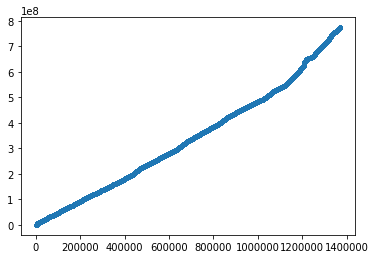

In [16]:
plt.plot(r['time'], marker='.')

In [18]:
r[0]

(8, 10, 5086, 82, 61, 82, 0, -8359.1, 0, [ 0,  1,  0,  2,  2,  2,  3,  1,  0, -2, -1,  0, -1,  0,  2,  1, -1,  2,  1, -2, -1, -2, -2, -1,  0, -2, -2,  2,  0,  0, -1,  1, -2,  0, -1,  2,  2,  2,  0, -1, 11, 13,  9,  8,  4,  2,  3,  1,  2,  1,  0,  1, -1,  1,  1,  1, -1, -1,  0,  2,  3, -2,  0, -2, -1, -2,  3,  2,  1,  1,  0, -2, -2, -1,  1,  0,  2, -1,  0,  2, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [6]:
st.make(run_id, 'records', config=dict(software_zle_channels = [8], extension=20))

[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  True  True ...  True  True  True]
20
[ True  Tr

In [7]:
bla = st.get_array(run_id, 'records')

In [8]:
bla

array([(8, 10,      5086,  82,  61,  82, 0, -8359.1  , 0, [ 0,  1,  0,  2,  2,  2,  3,  1,  0, -2, -1,  0, -1,  0,  2,  1, -1,  2,  1, -2, -1, -2, -2, -1,  0, -2, -2,  2,  0,  0, -1,  1, -2,  0, -1,  2,  2,  2,  0, -1, 11, 13,  9,  8,  4,  2,  3,  1,  2,  1,  0,  1, -1,  1,  1,  1, -1, -1,  0,  2,  3, -2,  0, -2, -1, -2,  3,  2,  1,  1,  0, -2, -2, -1,  1,  0,  2, -1,  0,  2, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
       (8, 10,      5946,  84, 113,  84, 0, -8358.575, 0, [ 1,  0, -1,  0,  0,  0,  0,  2, -1,  2,  3,  1, -2, -1,  0,  2,  0, -1,  0,  0, -2,  2,  2,  0, -3,  0,  0,  2,  1,  4,  2,  0,  2,  3,  1,  1,  1, -1,  0,  3,  6, 17, 14, 11,  2,  3,  1,  3,  2,  3,  3,  0,  2,  3,  3,  0,  1,  2,  0,  1,  2,  0,  0,  1,  0,  0, -1,  3,  3,  2,  0, -1,  1, -1, -1,  0,  1,  0,  2,  1,  1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [10]:
@export
@strax.takes_config(
    strax.Option('software_zle_channels', default = [], help= 'Channels to apply software ZLE to'),
    strax.Option('hitfinder_threshold', default = 15, help= 'Min ADC count threshold used if ZLE is applied'),
    strax.Option('extension', default=50, help='Number of samples to save around a hit')
)

                          
class Records(strax.Plugin):
    __version__ = '0.0.3'
    depends_on = ('raw_records',)
    data_kind = 'records'   # TODO: indicate cuts have been done?
    compressor = 'zstd'
    parallel = True
    rechunk_on_save = False
    dtype = strax.record_dtype()

    def compute(self, raw_records):
        r = raw_records[raw_records['channel'] in self.config['software_zle_channels']]
        if len(r) :
            hits = strax.find_hits(r)
            r = strax.cut_outside_hits(r, hits, left_extension=self.config['extension'],
                                                right_extension=self.config['extension'])
        raw_records[raw_records['channel'] in self.config['software_zle_channels']] = r
        return raw_records

NameError: name 'export' is not defined

In [5]:
%%time
st.make(run_id, 'raw_records')

CPU times: user 17.1 s, sys: 734 ms, total: 17.9 s
Wall time: 16.7 s


In [6]:
recs = st.get_array(run_id, 'raw_records')

In [7]:
recs

array([(8, 10,      5086,  82,  -61,  82, 0, 8359.1  , 0, [  0,  -1,   0,  -2,  -2,  -2,  -3,  -1,   0,   2,   1,   0,   1,   0,  -2,  -1,   1,  -2,  -1,   2,   1,   2,   2,   1,   0,   2,   2,  -2,   0,   0,   1,  -1,   2,   0,   1,  -2,  -2,  -2,   0,   1, -11, -13,  -9,  -8,  -4,  -2,  -3,  -1,  -2,  -1,   0,  -1,   1,  -1,  -1,  -1,   1,   1,   0,  -2,  -3,   2,   0,   2,   1,   2,  -3,  -2,  -1,  -1,   0,   2,   2,   1,  -1,   0,  -2,   1,   0,  -2,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
       (8, 10,      5946,  84, -113,  84, 0, 8358.575, 0, [ -1,   0,   1,   0,   0,   0,   0,  -2,   1,  -2,  -3,  -1,   2,   1,   0,  -2,   0,   1,   0,   0,   2,  -2,  -2,   0,   3,   0,   0,  -2,  -1,  -4,  -2,   0,  -2,  -3,  -1,  -1,  -1,   1,   0,  -3,  -6, -17, -14, -11,  -2,  -3,  -1,  -3,  -2,  -3,  -3,   0,  -2,  -3,  -3,   0,  -1,  -2,   0,  -1,  -2,   0,   0,  -1,   0,   0, 

In [ ]:
# passing only pulse location lists

In [7]:
%%time
st.make(run_id, 'raw_records')

CPU times: user 19.2 s, sys: 1.75 s, total: 21 s
Wall time: 19.7 s


In [5]:
%%time
st.make(run_id, 'raw_records')

CPU times: user 19.1 s, sys: 1.83 s, total: 20.9 s
Wall time: 20.2 s


In [5]:
%%time
st.make(run_id, 'raw_records')

CPU times: user 24.6 s, sys: 1.83 s, total: 26.5 s
Wall time: 25.2 s


In [8]:
%%time
st.make(run_id, 'raw_records')

CPU times: user 20.9 s, sys: 1.37 s, total: 22.2 s
Wall time: 21.2 s


In [ ]:
# Only decoding control words

In [5]:
%%time
st.make(run_id, 'raw_records')

CPU times: user 16.6 s, sys: 1.19 s, total: 17.7 s
Wall time: 16.9 s


In [ ]:
# No JIT

In [7]:
%%time
st.make(run_id, 'raw_records')

CPU times: user 33.8 s, sys: 1.39 s, total: 35.1 s
Wall time: 34.1 s


In [ ]:
raw_records = st.get_array(run_id, 'raw_records')

In [ ]:
raw_records['baseline']

In [6]:
peaks = st.get_array(run_id, 'peaks', config=dict(min_hits=1) )

In [ ]:
plt.hist(peaks['area'],bins=50,log=True)

In [ ]:
peaks = st.get_array(run_id, 'peaks', config=dict(min_hits=1))

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plot_peaks(main_i, n_before=0, n_after=0, label_threshold=0):
    for i in main_i + np.arange(-n_before, n_after + 1):
        p = peaks[i]
        label = None
        if p['area'] > label_threshold:
            label = '%.1f PE, %d ns dt' % (p['area'], p['dt'], )
        plot_peak(p,
                  t0=peaks[main_i]['time'],
                  label=label)
    plt.ylim(0, None)
    plt.legend(loc='upper right')
    #plt.yscale('symlog')

def plot_peak(p, t0=None, **kwargs):
    n = p['length']
    if t0 is None:
        t0 = p['time']
    plt.plot((p['time'] - t0) + np.arange(n) * p['dt'],
             p['data'][:n] / p['dt'],
             linestyle='steps-mid',
             **kwargs)
    plt.xlabel("Time (ns)")
    plt.ylabel("Sum waveform (PE / ns)")


In [ ]:
plot_peak(peaks[0])

In [ ]:
peaks

In [ ]:
amstrax.Peaks?